# Tema 2: Clasificación de barrios en función de su tipología.

In [1]:
import nltk                      # Natural Language Toolkit
import scrapy                    # Web scraping   
import requests                  # HTTP requests
import selenium                  # Web automation
import numpy as np               # Numerical computing
import pandas as pd              # Data manipulation
import seaborn as sns            # Data visualization
import tensorflow as tf          # Machine learning
import matplotlib.pyplot as plt  # Data visualization
import os                        # Operating system

!pip install openpyxl
import openpyxl                  # Excel files
import zipfile                   # Zip files
from copy import deepcopy        # Copy objects

from sklearn.cluster import KMeans # Clustering
from sklearn.preprocessing import StandardScaler # Data preprocessing
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from sklearn.manifold import TSNE # Dimensionality reduction

In [2]:
random_state = 666

## Automatización en la recogida de variables (dataset Barris)

Primero crearemos el diccionario `barrios_dict` donde se haga la asignación entre los nombres de los Barrios y el par distrito-barrio.

In [3]:
idBarrios = pd.read_csv('./data/barrios/barrios_codigos.csv', delimiter=';')
idBarrios = idBarrios[['Nombre', 'Codigo distrito', 'Codigo barrio']]

barrios_dict = {}

for index, row in idBarrios.iterrows():
    nombre = row['Nombre']
    codigo_distrito = row['Codigo distrito']
    codigo_barrio = row['Codigo barrio']
    
    barrio_dict = {
        'Codigo distrito': codigo_distrito,
        'Codigo barrio': codigo_barrio
    }
    
    barrios_dict[nombre] = barrio_dict

Definimos la función `get_barrio_name` que nos permite realizar la asignación distrito-barrio -> nombre del barrio.

In [4]:
def get_barrio_name(codigo_distrito, codigo_barrio):
    for nombre, barrio_dict in barrios_dict.items():
        if barrio_dict['Codigo distrito'] == codigo_distrito and barrio_dict['Codigo barrio'] == codigo_barrio:
            return nombre

Definimos a continuación unas funciones que nos ayudarán a extraer correctamente las tablas de las variables deseadas de los distintos excel.

In [5]:
def find_string_in_df(df, string):
    for i in range(len(df)):
        if string in str(df.iloc[i, 0]):
            return i
    return None

def find_skip(df, row):
    # Encontrar la primera fila que no esté completamente llena de NAs después de la fila especificada
    for i in range(row + 2, len(df)): # el +2 en lugar de +1 es para poder ponerlo en castellano xD
        if not df.iloc[i].isna().all():
            return i - row

    return 0  # Si todas las filas después de 'row' están completamente llenas de NAs, skip es 0

def extract_df(df, row, skip, n=None):
    if n is None:
        # Encontrar n dinámicamente.
        last_row = row + skip
        while last_row < len(df) and not df.iloc[last_row].isna().all():
            last_row += 1
        n = last_row - row - skip
    extracted_df = df.iloc[row + skip:row + skip + n, :]
    
    # Verificar si TODAS las filas en cada columna son NA
    columns_to_drop = extracted_df.columns[extracted_df.isna().all()]
    
    # Eliminar solo las columnas donde todas las filas son NA
    extracted_df = extracted_df.drop(columns_to_drop, axis=1)
    
    return extracted_df

def extract_df_by_string(df, string, n=None):
    row = find_string_in_df(df, string)
    skip = find_skip(df, row)
    return extract_df(df, row, skip, n)

In [6]:
#dataframes = { 'dfSup': dfSup,
#                    'dfPobSexEdad': dfPobSexEdad,
#                    'dfPobSexLugar': dfPobSexLugar,
#                    'dfPobExtCont': dfPobExtCont,
#                    'dfHojasFamComp': dfHojasFamComp,
#                    'dfIndicadoresDemograficosPadron': dfIndicadoresDemograficosPadron,
#                    'dfMovPadron': dfMovPadron,
#                    'dfIndicadoresDemograficosMovPadron': dfIndicadoresDemograficosMovPadron,
#                    'dfVehicTipo': dfVehicTipo,
#                    'dfTurismPot': dfTurismPot,
#                    'dfBienesInmAno': dfBienesInmAno,
#                    'dfBienesInmSup': dfBienesInmSup,
#                    'dfBienesInmVal': dfBienesInmVal,
#                    'dfBienesValMedio': dfBienesValMedio,
#                    'dfSupAparc': dfSupAparc,
#                    'dfElecGen': dfElecGen
#                 }

Se definen a continuación funciones para hacer un preprocesamiento de los diferentes datos que se adquirirán.

In [7]:
def clean_dataframe(df):
    # Eliminar filas y columnas con todos los valores NaN
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    # Establecer la primera fila como nombres de columnas y reindexar
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    return df

def modify_first_column_name(df, column_name):
    df.columns = [column_name] + list(df.columns[1:])
    return df
        
def extract_dataframes_from_excel(excel_path):
    dataframes = {}
    sheets = {
        'Padrón': ['Superficie y densidad de población', 'Población por sexo y edad (grandes grupos)',
                   'Población según lugar de nacimiento y sexo', 'Población extranjera según nacionalidad, por contienentes',
                   'Número de hojas familiares según composición', 'Indicadores demográficos'],
        'MovPadrón': ['Resumen de movimientos registrados en el Padrón Municipal', 'Indicadores demográficos'],
        'Vehículos': ['Vehículos según tipo', 'Turismos según potencia'],
        'Catastro': ['Bienes Inmuebles según el año de antigüedad',
                     'Bienes Inmuebles construidas después de 1800 según superficie construida',
                     'Bienes Inmuebles construidas después de 1800 según valor catastral',
                     'Valores catastrales medios', 'Superficie total de los aparcamientos'],
        'Elecciones': ['Votos a candidaturas']
    }
    
    for sheet, strings in sheets.items():
        df_sheet = pd.read_excel(excel_path, sheet_name=sheet)
        for string in strings:
            df = extract_df_by_string(df_sheet, string)
            if df is not None:
                df = clean_dataframe(df)
                if sheet == 'Padrón' and string in ['Población por sexo y edad (grandes grupos)', 'Población según lugar de nacimiento y sexo', 'Población extranjera según nacionalidad, por contienentes']:
                    modify_first_column_name(df, 'Género')
                elif sheet == 'Vehículos' and string == 'Vehículos según tipo':
                    modify_first_column_name(df, 'Tipo de vehículo')
                elif sheet == "Vehículos" and string == "Turismos según potencia":
                    modify_first_column_name(df, 'Potencia')
                elif sheet == 'Elecciones' and string == 'Votos a candidaturas':
                    modify_first_column_name(df, 'Partido')
                dataframes[f'{sheet}_{string.replace(" ", "_")}'] = df
    
    return dataframes


Esta función permite sacar el nombre del barrio infiriéndolo por el nombre del Excel (sigue la estructura de `Distrito_{num_distrito}_Barrio_{num_barrio}.xlsx`).

In [8]:
def get_barrio_name_from_filename(filename, barrios_dict):
    # Extraer el nombre del distrito y el número de barrio del nombre del archivo
    distrito_numero, barrio_numero = os.path.splitext(filename)[0].split('_')[1:4][::2]
    
    # Buscar el nombre del distrito y el número de barrio en barrios_dict
    for nombre, info_barrio in barrios_dict.items():
        if info_barrio['Codigo distrito'] == int(distrito_numero) and info_barrio['Codigo barrio'] == int(barrio_numero):
            return nombre
    
    return None

Se definen a continuación funciones que nos permitirán realizar el proceso de creación de la carpeta para un año concreto, descarga del zip correspondiente y su descompresión automática.

In [9]:
def download_zip(year):
    url = f'https://www.valencia.es/estadistica/inf_dtba/{year}/Barrios{year}.zip'
    response = requests.get(url)
    with open(f'./data/barrios/{year}/{year}.zip', 'wb') as file:
        file.write(response.content)

def create_folder(year):
    folder_path = f'./data/barrios/{year}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
def unzip_file(year):
    with zipfile.ZipFile(f'./data/barrios/{year}/{year}.zip', 'r') as zip_ref:
        zip_ref.extractall(f'./data/barrios/{year}')
        
def download_and_unzip(year):
    create_folder(year)
    download_zip(year)
    unzip_file(year)
    

Finalmente, la función `get_data` permite recibir una lista de años y devuelve los datos correctamente preprocesados ya para las variables que nos interesan.

In [10]:
def get_data(years):
    datos = {}
    for year in years:
        download_and_unzip(year)
        datos[year] = {}
        for filename in os.listdir(f'./data/barrios/{year}'):
            if filename.endswith('.xlsx'):
                excel_path = os.path.join(f'./data/barrios/{year}', filename)
                dataframes = extract_dataframes_from_excel(excel_path)
                barrio_name = get_barrio_name_from_filename(filename, barrios_dict)
                datos[year][barrio_name] = dataframes
    return datos

In [11]:
# Probar con lista de [2023, 2024] como year

years = [2023, 2024]

datosBarris = get_data(years)

In [12]:
datosBarris[2023]['BENICALAP']['Elecciones_Votos_a_candidaturas']

,Partido,Total
0,PARTIDO POPULAR,6553
1,COMPROMÍS PER VALÈNCIA: ACORD PER GUANYAR,4880
2,PARTIDO SOCIALISTA OBRERO ESPAÑOL,4689
3,VOX,2676
4,UNIDES PODEM-ESQUERRA UNIDA,448
5,CIUDADANOS-PARTIDO DE LA CIUDADANIA,408
6,PARTIDO ANIMALISTA CON EL MEDIO AMBIENTE (PACMA),216
7,VALENCIA UNIDA,96
8,ESCAÑOS EN BLANCO PARA DEJAR ESCAÑOS VACÍOS,30
9,PARTIDO COMUNISTA DE LOS PUEBLOS DE ESPAÑA,27


In [13]:
# Hacer que el bloque de partidos llamado Partidos_derecha sea constituido por los nombres PARTIDO POPULAR, VOX, CIUDADANOS-PARTIDO DE LA CIUDADANIA
# Hacer que el bloque de partidos llamados Partida_izquierda sea constituido por los nombres COMPROMÍS PER VALÈNCIA: ACORD PER GUANYAR, PARTIDO SOCIALISTA OBRERO ESPAÑOL, UNIDES PODEM-ESQUERRA UNIDA	

Partidos_derecha = ['PARTIDO POPULAR', 'VOX', 'CIUDADANOS-PARTIDO DE LA CIUDADANIA']
Partidos_izquierda = ['COMPROMÍS PER VALÈNCIA: ACORD PER GUANYAR', 'PARTIDO SOCIALISTA OBRERO ESPAÑOL', 'UNIDES PODEM-ESQUERRA UNIDA']

## Tidyficación para introducción en modelos

In [14]:
# Mirar keys de datosBarris
datosBarris[2023]['LA SEU'].keys()

dict_keys(['Padrón_Superficie_y_densidad_de_población', 'Padrón_Población_por_sexo_y_edad_(grandes_grupos)', 'Padrón_Población_según_lugar_de_nacimiento_y_sexo', 'Padrón_Población_extranjera_según_nacionalidad,_por_contienentes', 'Padrón_Número_de_hojas_familiares_según_composición', 'Padrón_Indicadores_demográficos', 'MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal', 'MovPadrón_Indicadores_demográficos', 'Vehículos_Vehículos_según_tipo', 'Vehículos_Turismos_según_potencia', 'Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad', 'Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida', 'Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral', 'Catastro_Valores_catastrales_medios', 'Catastro_Superficie_total_de_los_aparcamientos', 'Elecciones_Votos_a_candidaturas'])

In [15]:
datosBarris_tidy = deepcopy(datosBarris) # deepcopy es para que no se modifique el original, aplicable a objetos que contienen referencias a otros objetos

for year in years:
    for barrio in datosBarris_tidy[year].keys():
        
        # Padrón_Superficie_y_densidad_de_población --> hecho, cada variable está en una columna, solo hay que cambiar las columnas de nombre a ['Personas', 'Superficie', 'Densidad de población']
        # Originalmente se llaman ['Personas / Persones', 'Superficie / Superfície', 'Densidad de población / Densitat de població']
        
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Padrón_Superficie_y_densidad_de_población'])
        df_aux.columns = ['Personas', 'Superficie (hm²)', 'Densidad de población (p / hm²)']
        
        datosBarris_tidy[year][barrio]['Padrón_Superficie_y_densidad_de_población'] = df_aux.head(1)

        
        # Padrón_Población_por_sexo_y_edad_(grandes_grupos)
        
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Padrón_Población_por_sexo_y_edad_(grandes_grupos)'])
        df_aux['Porcentaje +65 años'] = df_aux['65 y más'] / df_aux['Total'] * 100
        datosBarris_tidy[year][barrio]['Padrón_Población_por_sexo_y_edad_(grandes_grupos)'] = df_aux[['Porcentaje +65 años']].head(1)
        
        # Padrón_Población_según_lugar_de_nacimiento_y_sexo -> nada relevante, en principio (borrar, ese dataframe de dentro de datosBarris_tidy)
        
        del datosBarris_tidy[year][barrio]['Padrón_Población_según_lugar_de_nacimiento_y_sexo']
        
        # Padrón_Población_extranjera_según_nacionalidad,_por_contienentes -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['Padrón_Población_extranjera_según_nacionalidad,_por_contienentes']
        
        # Padrón_Número_de_hojas_familiares_según_composición -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['Padrón_Número_de_hojas_familiares_según_composición']
        
        # Padrón_Indicadores_demográficos
        posiciones_variables = {
        'Edad media': 1,
        'Índice de envejecimiento': 2,
        'Índice de sobreenvejecimiento': 3,
        'Índice de estructura de la población activa': 5,
        'Porcentaje de población extranjera': 8
        }

        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Padrón_Indicadores_demográficos'])
        df_aux['Edad media'] = df_aux.iloc[posiciones_variables['Edad media'], 1]
        df_aux['Índice de envejecimiento'] = df_aux.iloc[posiciones_variables['Índice de envejecimiento'], 1]
        df_aux['Índice de sobreenvejecimiento'] = df_aux.iloc[posiciones_variables['Índice de sobreenvejecimiento'], 1]
        df_aux['Índice de estructura de la población activa'] = df_aux.iloc[posiciones_variables['Índice de estructura de la población activa'], 1]
        df_aux['Porcentaje de población extranjera'] = df_aux.iloc[posiciones_variables['Porcentaje de población extranjera'], 1]
        
        df_aux = df_aux.drop(df_aux.columns[[0, 1]], axis=1).head(1)
        datosBarris_tidy[year][barrio]['Padrón_Indicadores_demográficos'] = df_aux
        
        # MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal']
        
        # Igual que con lo de padrón de indicadores demográficos, pero cogiendo las variables 'Tasa bruta de natalidad', 
        # 'Tasa bruta de mortalidad', 'Tasa bruta de emigración intraurbana', 'Tasa bruta de emigración interurbana', 'Tasa general de fecundidad'
        
        posiciones_variables = {
        'Tasa bruta de natalidad': 1,
        'Tasa bruta de mortalidad': 2,
        'Tasa bruta de emigración intraurbana': 3,
        'Tasa bruta de emigración interurbana': 4,
        'Tasa general de fecundidad': 5
        }
        
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['MovPadrón_Indicadores_demográficos'])
        df_aux['Tasa bruta de natalidad'] = df_aux.iloc[posiciones_variables['Tasa bruta de natalidad'], 1]
        df_aux['Tasa bruta de mortalidad'] = df_aux.iloc[posiciones_variables['Tasa bruta de mortalidad'], 1]
        df_aux['Tasa bruta de emigración intraurbana'] = df_aux.iloc[posiciones_variables['Tasa bruta de emigración intraurbana'], 1]
        df_aux['Tasa bruta de emigración interurbana'] = df_aux.iloc[posiciones_variables['Tasa bruta de emigración interurbana'], 1]
        df_aux['Tasa general de fecundidad'] = df_aux.iloc[posiciones_variables['Tasa general de fecundidad'], 1]
        
        df_aux = df_aux.drop(df_aux.columns[[0, 1]], axis=1).head(1)
        datosBarris_tidy[year][barrio]['MovPadrón_Indicadores_demográficos'] = df_aux
        
        
        # Vehículos_Vehículos_según_tipo -> difícil de interpretar, no le veo del todo utilidad
        
        del datosBarris_tidy[year][barrio]['Vehículos_Vehículos_según_tipo']
        
        # Vehículos_Turismos_según_potencia -> difícil de interpretar
        
        del datosBarris_tidy[year][barrio]['Vehículos_Turismos_según_potencia']

        # Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad, necesito 
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad'])
        df_aux = df_aux.drop(columns = ['Total'])
        max_column = df_aux.iloc[0].idxmax()
        df_aux["Período de mayor construcción de inmuebles"] = max_column
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad'] = df_aux[['Período de mayor construcción de inmuebles']].head(1)
        
        # Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida'])[['Sup. construida media (m²)']]
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida'] = df_aux.head(1)
        
        # Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral
        # Hacer algo similar que lo de hallar término con más frecuencia
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral'])
        df_aux = df_aux.drop(columns = ['Total'])
        max_column = df_aux.iloc[0].idxmax()
        df_aux["Valor catastral máxima frecuencia (miles euros)"] = max_column
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral'] = df_aux[['Valor catastral máxima frecuencia (miles euros)']].head(1)
        
        # Catastro_Valores_catastrales_medios
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Valores_catastrales_medios'])[['Valor por m²']]
        
        datosBarris_tidy[year][barrio]['Catastro_Valores_catastrales_medios'] = df_aux.head(1)
        
        # Catastro_Superficie_total_de_los_aparcamientos -> no la veo muy relevante
        
        del datosBarris_tidy[year][barrio]['Catastro_Superficie_total_de_los_aparcamientos']
        
        # Elecciones_Votos_a_candidaturas
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Elecciones_Votos_a_candidaturas'])
        # Hacer la suma de Partidos_derecha y Partidos_izquierda (hay que filtrar por Partido == y coger los valores de la columna "Total")
        
        df_aux['Partidos_derecha'] = df_aux[df_aux['Partido'].isin(Partidos_derecha)]['Total'].sum()
        df_aux['Partidos_izquierda'] = df_aux[df_aux['Partido'].isin(Partidos_izquierda)]['Total'].sum()
        
        # Sacar el coeficiente derecha - izquierda haciendo la proporción
        df_aux['Coeficiente derecha - izquierda'] = df_aux['Partidos_derecha'] / df_aux['Partidos_izquierda']
        
        # Añadir a la última columna y quedarme solo con ese valor como dataframe, igual que en casos anteriores
        
        datosBarris_tidy[year][barrio]['Elecciones_Votos_a_candidaturas'] = df_aux[['Coeficiente derecha - izquierda']].head(1)
        
        # MERGE de todos los dataframes anteriores
        
        datosBarris_tidy[year][barrio] = pd.concat([datosBarris_tidy[year][barrio][key] for key in datosBarris_tidy[year][barrio].keys()], axis=1)

In [16]:
datosBarris_tidy[2023]['BENICALAP']

,Personas,Superficie (hm²),Densidad de población (p / hm²),Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,Índice de estructura de la población activa,Porcentaje de población extranjera,Tasa bruta de natalidad,Tasa bruta de mortalidad,Tasa bruta de emigración intraurbana,Tasa bruta de emigración interurbana,Tasa general de fecundidad,Período de mayor construcción de inmuebles,Sup. construida media (m²),Valor catastral máxima frecuencia (miles euros),Valor por m²,Coeficiente derecha - izquierda
0,42725,171.895,248.552896,18.291398,43,120.2,13.9,137.9,16.5,50,59.2,8.1,43.3,34.9,1961-80,104.176912,36-48,408.03034,0.962064


Vamos a poner ahora para cada año todo en un mismo dataframe. Las filas serán los distintos barrios.

In [17]:
# Necesito tener un datosBarris_tidy[year] en el que cada barrio sea una fila y cada variable una columna (concatenar todos los dataframes iterando sobre barrio). La primera columna debe ser el nombre del barrio en este dataframe

datosBarris_tidy_final = {}

for year in years:
    datosBarris_tidy_final[year] = pd.concat([datosBarris_tidy[year][barrio] for barrio in datosBarris_tidy[year].keys()], axis=0)
    datosBarris_tidy_final[year].insert(0, 'Barrio', datosBarris_tidy[year].keys())
    datosBarris_tidy_final[year].insert(1, 'Código distrito', [barrios_dict[barrio]['Codigo distrito'] for barrio in datosBarris_tidy[year].keys()])
    datosBarris_tidy_final[year].insert(2, 'Código barrio', [barrios_dict[barrio]['Codigo barrio'] for barrio in datosBarris_tidy[year].keys()])

# Ordenar por conjunto (Codigo distrito, Codigo barrio)

for year in years:
    datosBarris_tidy_final[year] = datosBarris_tidy_final[year].sort_values(by=['Código distrito', 'Código barrio']).reset_index(drop=True)

datosBarris_tidy_final[2023]

,Barrio,Código distrito,Código barrio,Personas,Superficie (hm²),Densidad de población (p / hm²),Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,...,Tasa bruta de natalidad,Tasa bruta de mortalidad,Tasa bruta de emigración intraurbana,Tasa bruta de emigración interurbana,Tasa general de fecundidad,Período de mayor construcción de inmuebles,Sup. construida media (m²),Valor catastral máxima frecuencia (miles euros),Valor por m²,Coeficiente derecha - izquierda
0,LA SEU,1,1,3151,22.107,142.534039,19.612821,44.6,176.6,16.2,...,40.0,106.5,11.8,58.5,50.2,1801-1900,124.265811,>72,498.042502,1.348101
1,LA XEREA,1,2,4002,31.165,128.413284,23.688156,46.2,189.6,17.7,...,40.0,84.4,14.6,53.5,36.2,1961-80,149.418803,>72,559.042185,3.737945
2,EL CARME,1,3,6896,38.407,179.550603,18.793503,44.6,165.7,19.9,...,52.8,98.4,11.2,54.6,50.2,1961-80,96.93443,36-48,385.432379,0.694764
3,EL PILAR,1,4,4921,16.161,304.498484,16.602317,42.9,131.8,18.6,...,54.6,126.2,11.8,56.7,62.5,2001-10,106.484838,>72,414.454049,0.884058
4,EL MERCAT,1,5,3936,17.279,227.79096,17.352642,43.0,152.5,13.2,...,40.5,117.7,7.0,59.1,40.7,1801-1900,110.176146,>72,496.671704,1.203106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,EL SALER,19,4,1930,824.754,2.340092,19.533679,43.4,118.2,7.7,...,12.5,63.8,6.8,46.0,39.2,1961-80,117.756874,48-60,423.959823,1.061966
83,EL PALMAR,19,5,749,3696.154,0.202643,29.906542,49.2,238.3,20.1,...,101.9,13.2,13.2,29.1,29.1,1961-80,156.457143,18-24,287.717921,0.959514
84,EL PERELLONET,19,6,1475,492.815,2.99301,20.067797,45.8,149.5,8.1,...,165.4,56.7,6.1,70.2,47.2,1961-80,109.276293,36-48,437.132097,1.616667
85,LA TORRE,19,7,4969,41.956,118.433597,21.674381,44.5,159.6,10.5,...,17.3,69.1,5.7,33.7,52.2,1961-80,101.70633,24-30,285.234912,0.887704


Borrado de algunos dataframes que ya no nos vayan a servir para ahorrar RAM

In [18]:
del datosBarris_tidy

### Visualización de algunas variables

c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

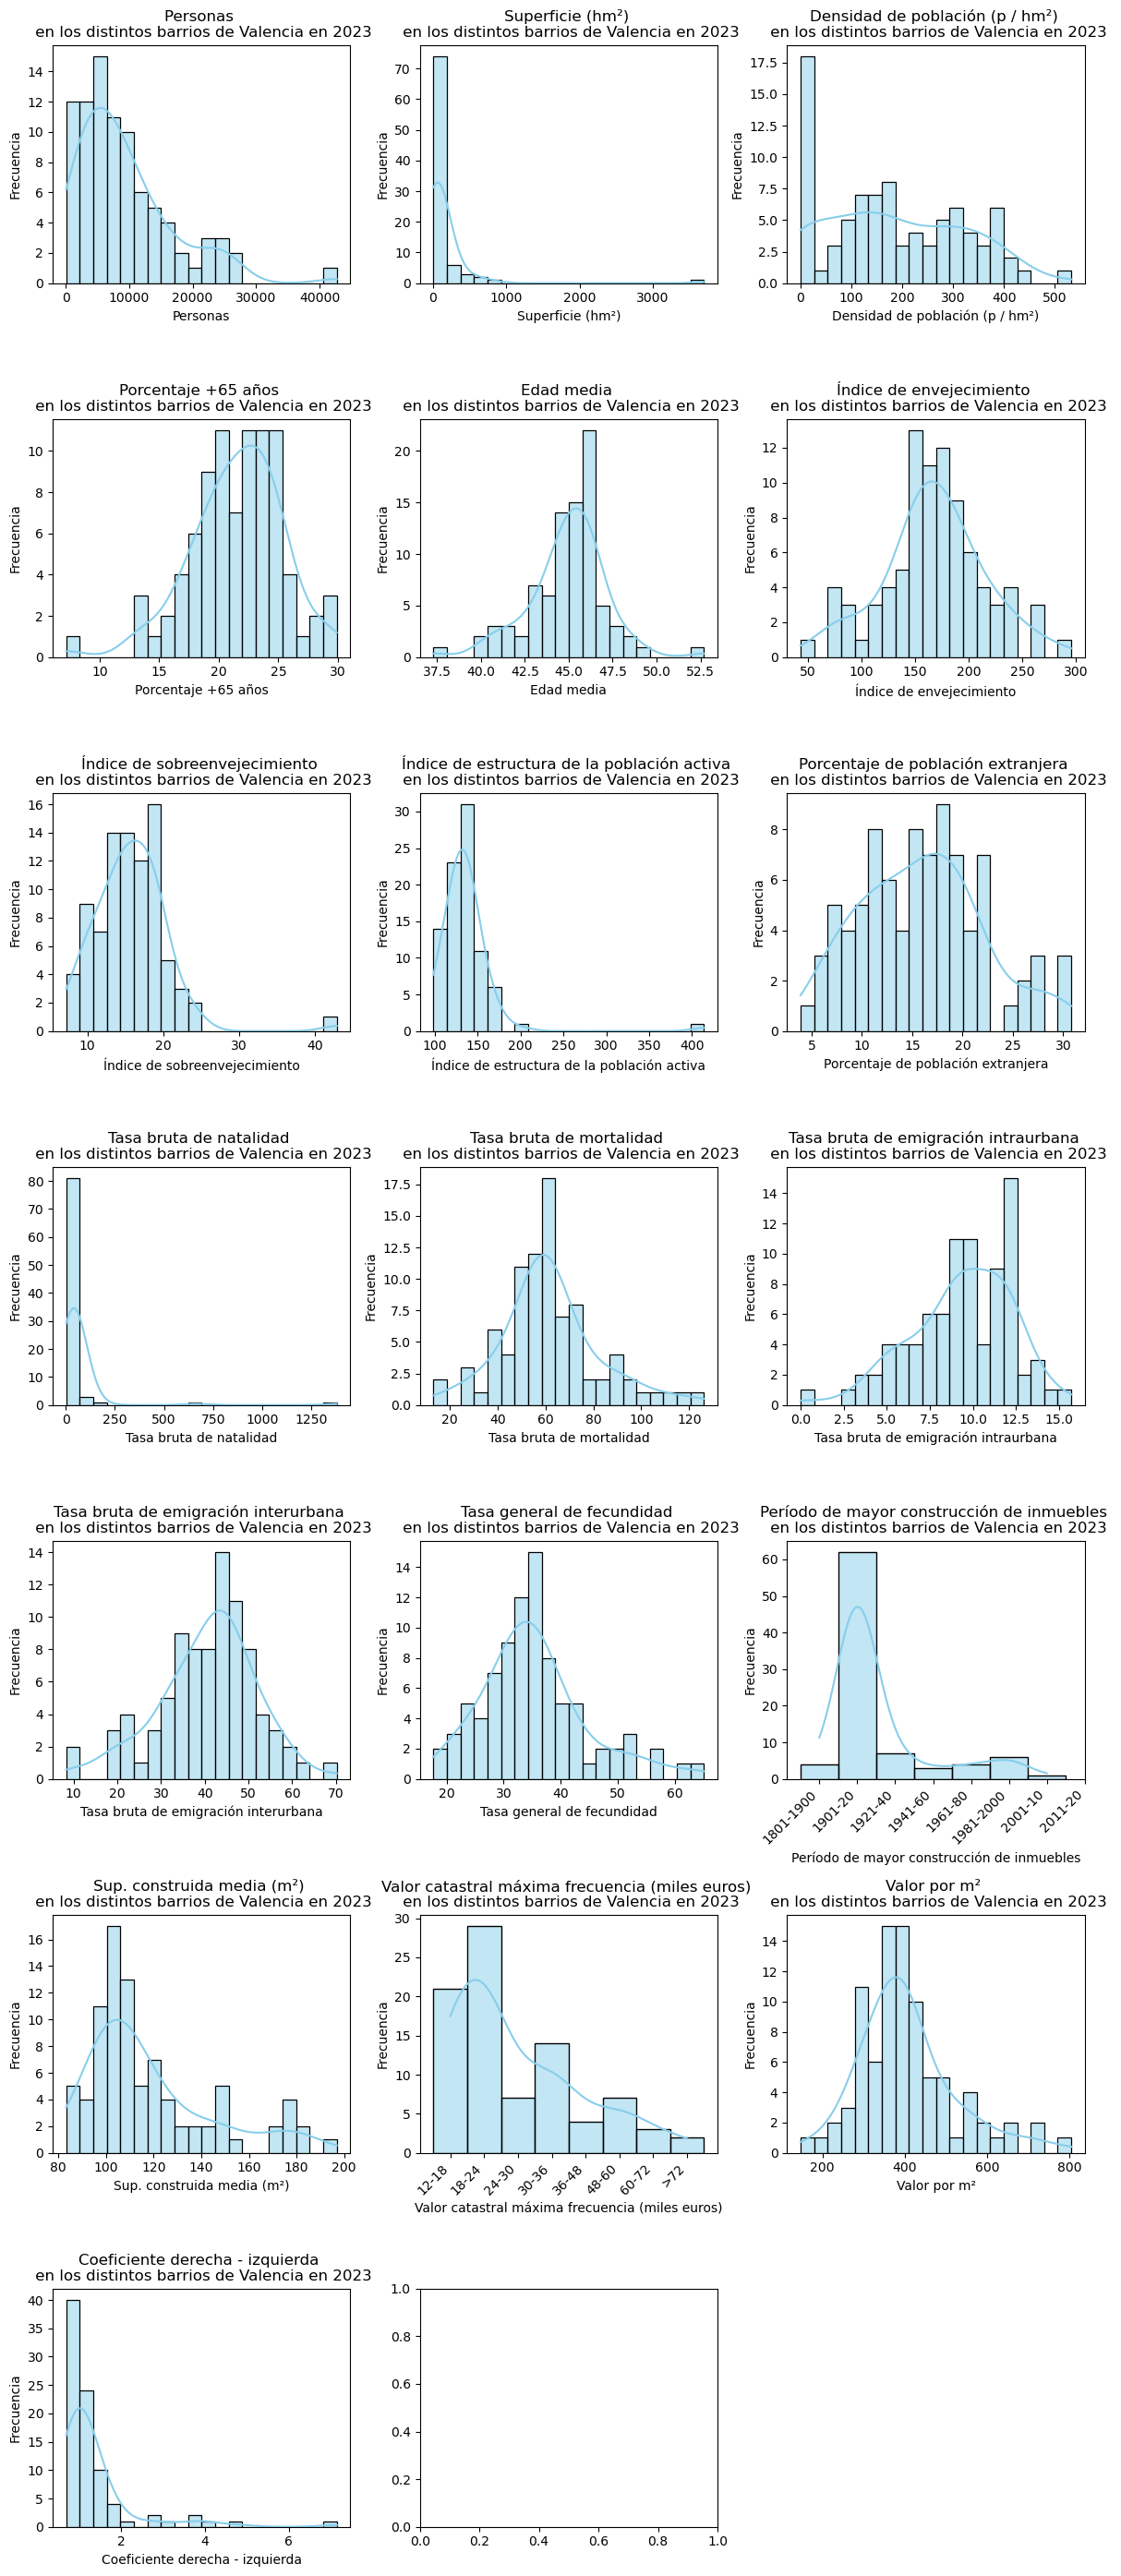

c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

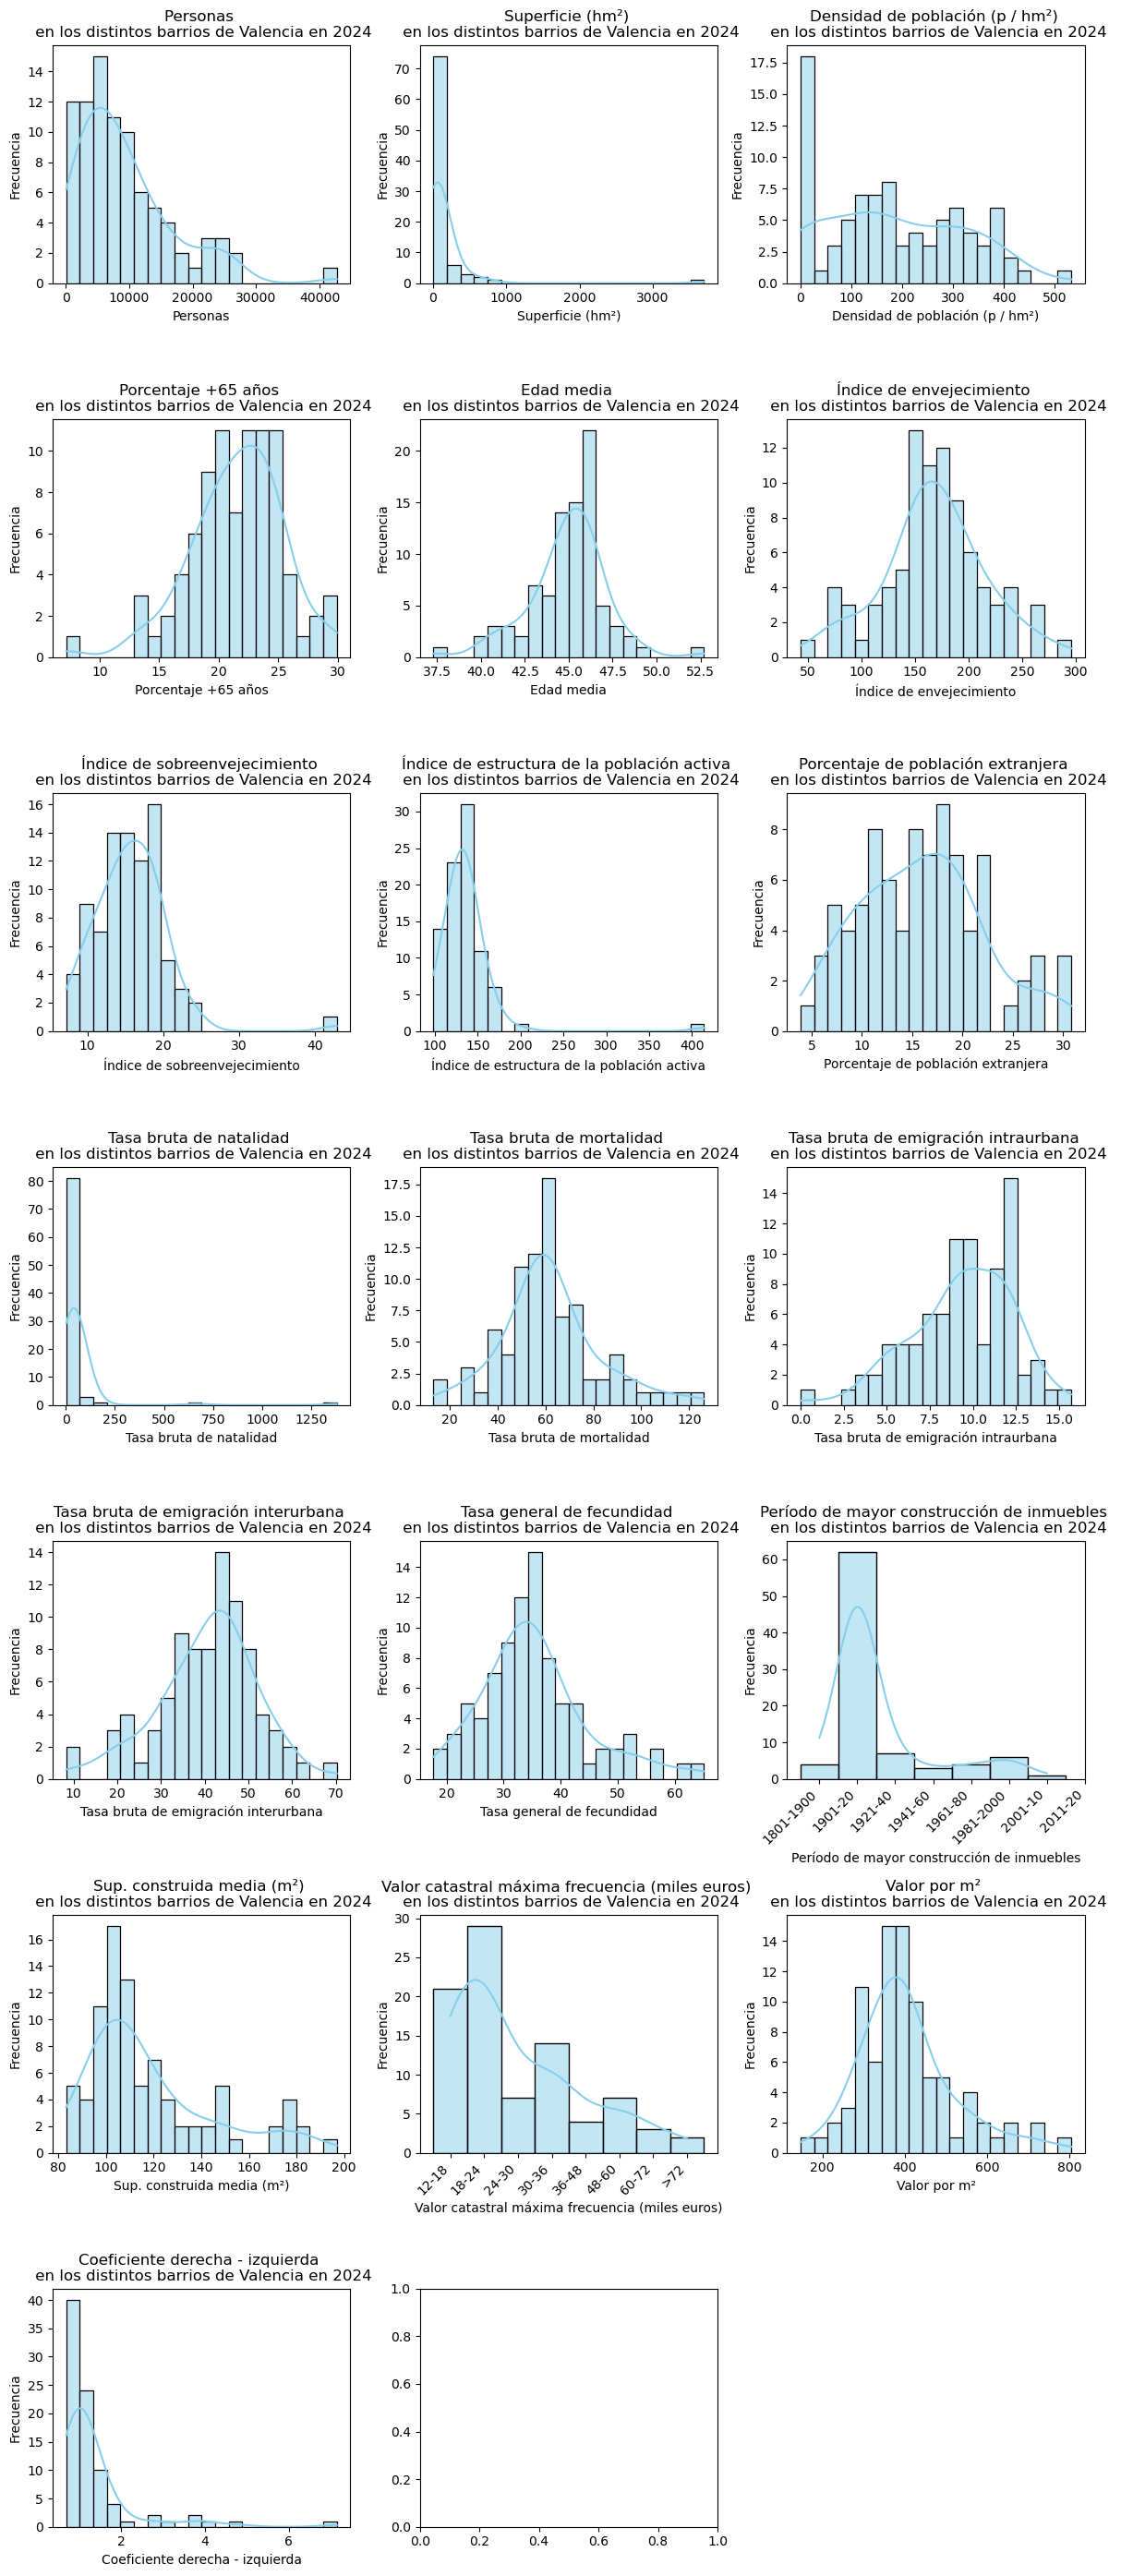

In [19]:
ordenInmueble = ['1801-1900', '1901-20', '1921-40', '1941-60', '1961-80', '1981-2000', '2001-10', '2011-20']
ordenCatastro = ['12-18', '18-24', '24-30', '30-36', '36-48', '48-60', '60-72', '>72']

# Cambiar lo de plot_histograms_final para que deje elegir el número de columnas que va haber. En función de eso que se haga de manera inteligente el número de filas

def plot_histograms_final(datos, year, variables, bins=20, kde=True, color='skyblue', title=None, n_cols=2):
    n_variables = len(variables)
    n_rows = int(n_variables / n_cols) if n_variables % n_cols == 0 else int(n_variables / n_cols) + 1
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axs = axs.flatten()
    
    for i, variable in enumerate(variables):
        valores = datos[year][variable]

        sns.histplot(valores, bins=bins, kde=kde, color=color, ax=axs[i])
        
        if variable == 'Período de mayor construcción de inmuebles':
            axs[i].set_xticks(range(len(ordenInmueble)))
            axs[i].set_xticklabels(ordenInmueble, rotation=45, ha='right')
        elif variable == 'Valor catastral máxima frecuencia (miles euros)':
            axs[i].set_xticks(range(len(ordenCatastro)))
            axs[i].set_xticklabels(ordenCatastro, rotation=45, ha='right')
        
        axs[i].set_xlabel(variable)
        axs[i].set_ylabel('Frecuencia')
        
        if title is None:
            axs[i].set_title(f'{variable} \n en los distintos barrios de Valencia en {year}')
        else:
            axs[i].set_title(title)

    if n_variables % n_cols != 0:
        fig.delaxes(axs[-1])

    plt.tight_layout()
    plt.show()

# Coger todas las variables disponibles

variables = [column for column in datosBarris_tidy_final[2023].columns if column not in ['Barrio', 'Código distrito', 'Código barrio']]

plot_histograms_final(datosBarris_tidy_final, 2023, variables, title=None, n_cols=3)
plot_histograms_final(datosBarris_tidy_final, 2024, variables, title=None, n_cols=3)


Aclaraciones:

- Índice de envejecimiento: porcentaje de personas mayores de 64 años respecto de menores de 16 años.
- Índice de sobreenvejecimiento: porcentaje de personas de más de 85 años o más respecto de los de 65 años o más.
- Índice de estructura de la población activa: relación entre la población entre 40 y 64 años y la de entre 15 y 39.
- Tasa bruta de emigración intraurbana: se refiere a la cantidad de personas que se mudan a un área urbana (por cada 1000 habitantes).
- Tasa bruta de emigración interurbana: se refiere a la cantidad de personas que se mudan fuera de la región (por cada 1000 habitantes).
- Tasa bruta de natalidad: número promedio de personas que nacen por cada 1000 habitantes.

In [20]:
def filter_data(datos, year, variables, values, logicals):
    df = datos[year]
    for variable, value, logical in zip(variables, values, logicals):
        if variable == 'Barrio':
            df = df[df[variable].str.contains(value, case=False, na=False)]
        else:
            if logical == '>':
                df = df[df[variable] > value]
            elif logical == '<':
                df = df[df[variable] < value]
            elif logical == '>=':
                df = df[df[variable] >= value]
            elif logical == '<=':
                df = df[df[variable] <= value]
            elif logical == '==':
                df = df[df[variable] == value]
            elif logical == '!=':
                df = df[df[variable] != value]
    return df

Filtrados.

In [21]:
filter_data(datosBarris_tidy_final, 2023, 
            variables = ['Porcentaje de población extranjera', 'Valor por m²'], 
            values = [30, 310], 
            logicals = ['>', '>'])

# Filtrar por coeficiente derecha - izquierda mayor a 6

filter_data(datosBarris_tidy_final, 2023,
            variables = ['Coeficiente derecha - izquierda'],
            values = [0.7],
            logicals = ['<'])

,Barrio,Código distrito,Código barrio,Personas,Superficie (hm²),Densidad de población (p / hm²),Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,...,Tasa bruta de natalidad,Tasa bruta de mortalidad,Tasa bruta de emigración intraurbana,Tasa bruta de emigración interurbana,Tasa general de fecundidad,Período de mayor construcción de inmuebles,Sup. construida media (m²),Valor catastral máxima frecuencia (miles euros),Valor por m²,Coeficiente derecha - izquierda
2,EL CARME,1,3,6896,38.407,179.550603,18.793503,44.6,165.7,19.9,...,52.8,98.4,11.2,54.6,50.2,1961-80,96.93443,36-48,385.432379,0.694764


In [22]:
filter_data(datosBarris_tidy_final, 2023,
            variables = ['Barrio'],
            values = ['el pla'],
            logicals = ['=='])

,Barrio,Código distrito,Código barrio,Personas,Superficie (hm²),Densidad de población (p / hm²),Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,...,Tasa bruta de natalidad,Tasa bruta de mortalidad,Tasa bruta de emigración intraurbana,Tasa bruta de emigración interurbana,Tasa general de fecundidad,Período de mayor construcción de inmuebles,Sup. construida media (m²),Valor catastral máxima frecuencia (miles euros),Valor por m²,Coeficiente derecha - izquierda
7,EL PLA DEL REMEI,2,2,7094,38.692,183.345394,26.430787,46.5,182.0,19.5,...,33.0,58.0,8.9,40.4,29.6,1961-80,175.486659,>72,804.697259,7.14032


## Clustering

In [66]:
ordenInmueble = ['1801-1900', '1901-20', '1921-40', '1941-60', '1961-80', '1981-2000', '2001-10', '2011-20']
ordenCatastro = ['12-18', '18-24', '24-30', '30-36', '36-48', '48-60', '60-72', '>72']

numInmueble = ['1850', '1910', '1930', '1950', '1970', '1990', '2005', '2015']
numCatastro = ['15', '21', '27', '33', '42', '54', '66', '80']

# Hacer que datosBarris_tidy_final sustituya los valores de las columnas 'Período de mayor construcción de inmuebles' y 'Valor catastral máxima frecuencia (miles euros)' por los valores de numInmueble y numCatastro tras hacer una asignación con lo de ordenInmueble, ordenCatastro
# Que esto esté en un dataframe llamado datosBarris_tidy_clustering

datosBarris_tidy_clustering = deepcopy(datosBarris_tidy_final)

for year in years:
    df = datosBarris_tidy_clustering[year]
    df['Período de mayor construcción de inmuebles'] = df['Período de mayor construcción de inmuebles'].replace(ordenInmueble, numInmueble)
    df['Valor catastral máxima frecuencia (miles euros)'] = df['Valor catastral máxima frecuencia (miles euros)'].replace(ordenCatastro, numCatastro)

In [67]:
year_sel = years[0]

variables_clustering = [column for column in datosBarris_tidy_clustering[year_sel].columns if column
                        not in ['Barrio', 'Código distrito', 'Código barrio', 'Personas', 'Superficie (hm²)', 'Cluster']]

In [68]:
# Hacer método del codo para saber qué número de clusters hacer

def elbow_method(datos, year, max_clusters, variables):
    df = datos[year]
    X = df[variables]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=None)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Distorsión')
    plt.title(f'Método del codo para {year}')
    plt.show()

#elbow_method(datosBarris_tidy_clustering, 2023, 20, variables_clustering)

In [69]:
def clustering(datos, year, n_clusters, variables):
    df = datos[year]
    X = df[variables]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=None)
    df['Cluster'] = kmeans.fit_predict(X_scaled)
    return df

nClusters = 9

for year in years:
    variables_clustering = [column for column in datosBarris_tidy_clustering[year].columns if column not in ['Barrio', 'Código distrito', 'Código barrio', 'Personas', 'Superficie (hm²)', 'Cluster']]
    datosBarris_tidy_clustering[year] = clustering(datosBarris_tidy_clustering, year, nClusters, variables_clustering)

c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to ha

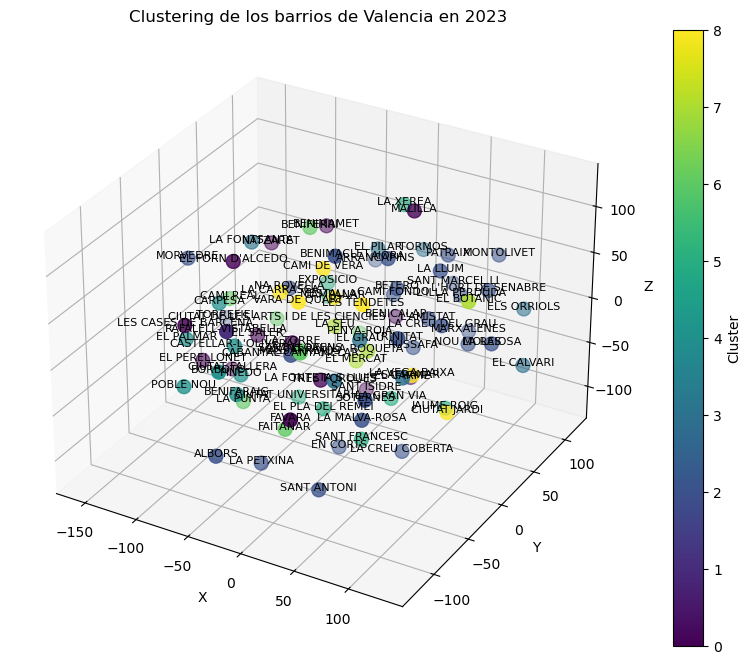

In [70]:
def plot_clustering_3d(datos, year, variables):
    df = datos[year]
    X = df[variables]
    
    # Reducción de dimensionalidad a 3 componentes usando t-SNE
    tsne = TSNE(n_components=3, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    
    # Agregar los componentes a DataFrame
    df['X'] = X_tsne[:, 0]
    df['Y'] = X_tsne[:, 1]
    df['Z'] = X_tsne[:, 2]
    
    # Plot 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(df['X'], df['Y'], df['Z'], c=df['Cluster'], cmap='viridis', s=100)
    
    # Etiquetas de los barrios
    for i in range(len(df)):
        ax.text(df['X'][i], df['Y'][i], df['Z'][i], df['Barrio'][i], fontsize=8, ha='center')
    
    ax.set_title(f'Clustering de los barrios de Valencia en {year}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Barra de colores
    legend = plt.colorbar(scatter)
    legend.set_label('Cluster')
    
    plt.show()

plot_clustering_3d(datosBarris_tidy_clustering, 2023, variables_clustering)

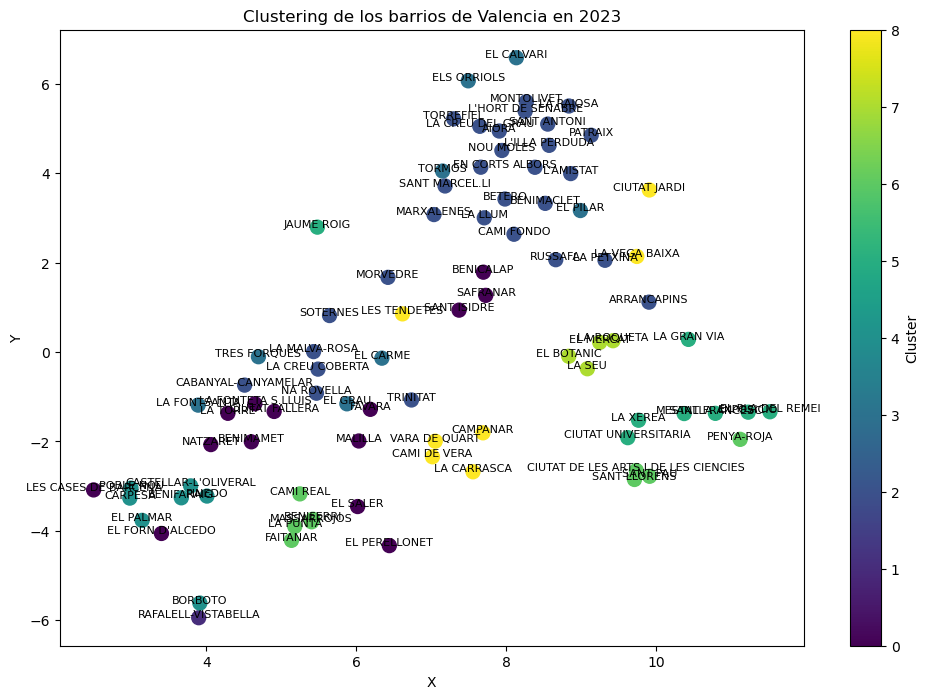

In [71]:
# Hacer igual que lo de arriba pero para 2D solo

def plot_clustering_2d(datos, year, variables, n_clusters):
    df = datos[year]
    X = df[variables]
    
    # Reducción de dimensionalidad a 2 componentes usando t-SNE
    tsne = TSNE(n_components=2, random_state= random_state)
    X_tsne = tsne.fit_transform(X)
    
    # Agregar los componentes a DataFrame
    df['X'] = X_tsne[:, 0]
    df['Y'] = X_tsne[:, 1]
    
    # Plot 2D
    fig = plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['X'], df['Y'], c=df['Cluster'], cmap='viridis', s=100)
    
    # Etiquetas de los barrios
    for i in range(len(df)):
        plt.text(df['X'][i], df['Y'][i], df['Barrio'][i], fontsize=8, ha='center')
    
    plt.title(f'Clustering de los barrios de Valencia en {year}')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Barra de colores
    legend = plt.colorbar(scatter)
    legend.set_label('Cluster')
    
    plt.show()

plot_clustering_2d(datosBarris_tidy_clustering, 2023, variables_clustering, 5)

## Búsqueda de algún patrón interesante

In [72]:
def plot_variables_vs_variables(datos, year, variable_x, variable_y):
    df = datos[year]
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(df[variable_x], df[variable_y], c=df['Cluster'], cmap='viridis', s=100)
    
    for i in range(len(df)):
        ax.text(df[variable_x][i], df[variable_y][i], df['Barrio'][i], fontsize=8, ha='center')
    
    ax.set_title(f'{variable_x} vs {variable_y} en los barrios de Valencia en {year}')
    ax.set_xlabel(variable_x)
    ax.set_ylabel(variable_y)
    
    legend = plt.colorbar(scatter)
    legend.set_label('Cluster')
    
    plt.show()

### ¿Relación entre porcentaje de extranjería y coeficiente derecha - izquierda?

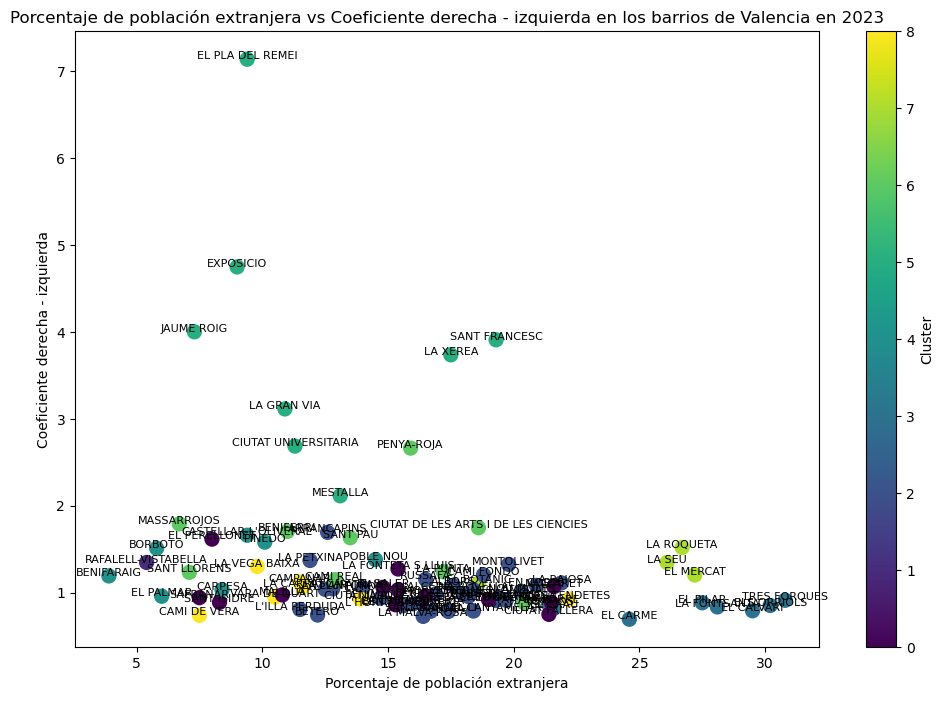

In [73]:
plot_variables_vs_variables(datosBarris_tidy_clustering, 2023, 'Porcentaje de población extranjera', 'Coeficiente derecha - izquierda')

## Creación del modelo de reglas a partir de las etiquetas de Samu

Dado que mi compañero tiene las cosas hechas por distritos, se opta por hacer un promedio de mis datos por distritos y hacer el análisis en ellos.

In [74]:
# mostrar el tipo de cada columna

datosBarris_tidy_clustering[2023].dtypes

Barrio                                              object
Código distrito                                      int64
Código barrio                                        int64
Personas                                            object
Superficie (hm²)                                    object
Densidad de población (p / hm²)                     object
Porcentaje +65 años                                 object
Edad media                                         float64
Índice de envejecimiento                           float64
Índice de sobreenvejecimiento                      float64
Índice de estructura de la población activa        float64
Porcentaje de población extranjera                 float64
Tasa bruta de natalidad                            float64
Tasa bruta de mortalidad                           float64
Tasa bruta de emigración intraurbana               float64
Tasa bruta de emigración interurbana               float64
Tasa general de fecundidad                         float

In [75]:
datosBarris_tidy_clustering[2023]

,Barrio,Código distrito,Código barrio,Personas,Superficie (hm²),Densidad de población (p / hm²),Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,...,Tasa general de fecundidad,Período de mayor construcción de inmuebles,Sup. construida media (m²),Valor catastral máxima frecuencia (miles euros),Valor por m²,Coeficiente derecha - izquierda,Cluster,X,Y,Z
0,LA SEU,1,1,3151,22.107,142.534039,19.612821,44.6,176.6,16.2,...,50.2,1850,124.265811,80,498.042502,1.348101,7,9.083412,-0.374104,-10.212307
1,LA XEREA,1,2,4002,31.165,128.413284,23.688156,46.2,189.6,17.7,...,36.2,1970,149.418803,80,559.042185,3.737945,5,9.766582,-1.525521,100.498215
2,EL CARME,1,3,6896,38.407,179.550603,18.793503,44.6,165.7,19.9,...,50.2,1970,96.93443,42,385.432379,0.694764,3,6.341833,-0.137269,8.327913
3,EL PILAR,1,4,4921,16.161,304.498484,16.602317,42.9,131.8,18.6,...,62.5,2005,106.484838,80,414.454049,0.884058,3,8.990316,3.165272,55.871944
4,EL MERCAT,1,5,3936,17.279,227.79096,17.352642,43.0,152.5,13.2,...,40.7,1850,110.176146,80,496.671704,1.203106,7,9.247788,0.215787,-47.332947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,EL SALER,19,4,1930,824.754,2.340092,19.533679,43.4,118.2,7.7,...,39.2,1970,117.756874,54,423.959823,1.061966,0,6.018428,-3.456739,-14.349279
83,EL PALMAR,19,5,749,3696.154,0.202643,29.906542,49.2,238.3,20.1,...,29.1,1970,156.457143,21,287.717921,0.959514,4,3.143092,-3.765893,6.973296
84,EL PERELLONET,19,6,1475,492.815,2.99301,20.067797,45.8,149.5,8.1,...,47.2,1970,109.276293,42,437.132097,1.616667,0,6.441612,-4.330853,-36.949451
85,LA TORRE,19,7,4969,41.956,118.433597,21.674381,44.5,159.6,10.5,...,52.2,1970,101.70633,27,285.234912,0.887704,0,4.287168,-1.370545,4.256220


In [76]:
# Hacer la conversión de las columnas a float64 salvo de la de 'Barrio', tampoco las que sean int64 o int32 en datosBarris_tidy_clustering

for year in years:
    df = datosBarris_tidy_clustering[year]
    for column in df.columns:
        if column not in ['Barrio', 'Código distrito', 'Código barrio', 'Cluster']:
            if df[column].dtype != 'int64' and df[column].dtype != 'int32':
                df[column] = df[column].astype('float64')

In [84]:
datosBarris_tidy_clustering[2023].dtypes

Barrio                                              object
Código distrito                                      int64
Código barrio                                        int64
Personas                                           float64
Superficie (hm²)                                   float64
Densidad de población (p / hm²)                    float64
Porcentaje +65 años                                float64
Edad media                                         float64
Índice de envejecimiento                           float64
Índice de sobreenvejecimiento                      float64
Índice de estructura de la población activa        float64
Porcentaje de población extranjera                 float64
Tasa bruta de natalidad                            float64
Tasa bruta de mortalidad                           float64
Tasa bruta de emigración intraurbana               float64
Tasa bruta de emigración interurbana               float64
Tasa general de fecundidad                         float

In [86]:
# De datos_tidy_clustering tengo que hacer un promedio para los distintos barrios agrupando por distrito, para tener al final un dataframe con los datos de los distritos.
# Debe desaparecer la columna Barrio, Código barrioy en su lugar debe aparecer la columna Distrito y Código distrito (esta última ya está). También quitar las 3 últimas columnas ('X', 'Y', 'Z')

datosDistritos = {}

for year in years:
    datosDistritos[year] = datosBarris_tidy_clustering[year].groupby('Código distrito').mean().reset_index()
    datosDistritos[year] = datosDistritos[year].drop(columns=['X', 'Y', 'Z'])
    
datosDistritos[2023]
# Para las columnas de 'Personas', 'Superficie (hm²)' hacer una suma en lugar de la media
# Para la columna de 'Densidad de población (p / hm²)' recalcularla a partir de la suma de 'Personas' y 'Superficie (hm²)'
# El resto de columnas tienen que quedar con la media que dije antes.
# Modifica eso de antes para agregar esto en especial. En el resto de columnas se hace la mean



TypeError: agg function failed [how->mean,dtype->object]